In [1]:
from gensim.models import word2vec
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#sentences = word2vec.Text8Corpus('text8')
#model = word2vec.Word2Vec(sentences, size=100)

In [3]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Data preparation

Загрузим набор текстов из экономического журнала, размеченных по темам.

In [4]:
X, y = [], []
with open('r8-no-stop.txt') as infile:
    for line in infile:
        label, text = line.split("\t")
        # texts are already tokenized, just split on space
        # in a real case we would use e.g. spaCy for tokenization
        # and maybe remove stopwords etc.
        X.append(text.split())
        y.append(label)
X, y = np.array(X), np.array(y)

In [177]:
X[0]

['asian',
 'exporters',
 'fear',
 'damage',
 'japan',
 'rift',
 'mounting',
 'trade',
 'friction',
 'and',
 'japan',
 'raised',
 'fears',
 'asia',
 'exporting',
 'nations',
 'that',
 'row',
 'inflict',
 'reaching',
 'economic',
 'damage',
 'businessmen',
 'and',
 'officials',
 'told',
 'reuter',
 'correspondents',
 'asian',
 'capitals',
 'move',
 'japan',
 'boost',
 'protectionist',
 'sentiment',
 'and',
 'lead',
 'curbs',
 'american',
 'imports',
 'products',
 'exporters',
 'that',
 'conflict',
 'hurt',
 'long',
 'run',
 'short',
 'term',
 'tokyo',
 'loss',
 'gain',
 'will',
 'impose',
 'mln',
 'dlrs',
 'tariffs',
 'imports',
 'japanese',
 'electronics',
 'goods',
 'april',
 'retaliation',
 'for',
 'japan',
 'alleged',
 'failure',
 'stick',
 'pact',
 'not',
 'sell',
 'semiconductors',
 'world',
 'markets',
 'below',
 'cost',
 'unofficial',
 'japanese',
 'estimates',
 'put',
 'impact',
 'tariffs',
 'billion',
 'dlrs',
 'and',
 'spokesmen',
 'for',
 'major',
 'electronics',
 'firms',
 '

Обучим word2vec на наших текстах.

In [5]:
model = word2vec.Word2Vec(X, size=100, window=5, workers=2)

2017-04-23 20:39:19,527 : INFO : collecting all words and their counts
2017-04-23 20:39:19,528 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-04-23 20:39:19,658 : INFO : collected 22931 word types from a corpus of 495226 raw words and 7674 sentences
2017-04-23 20:39:19,659 : INFO : Loading a fresh vocabulary
2017-04-23 20:39:19,702 : INFO : min_count=5 retains 7367 unique words (32% of original 22931, drops 15564)
2017-04-23 20:39:19,703 : INFO : min_count=5 leaves 468792 word corpus (94% of original 495226, drops 26434)
2017-04-23 20:39:19,745 : INFO : deleting the raw counts dictionary of 22931 items
2017-04-23 20:39:19,751 : INFO : sample=0.001 downsamples 39 most-common words
2017-04-23 20:39:19,752 : INFO : downsampling leaves estimated 385730 word corpus (82.3% of prior 468792)
2017-04-23 20:39:19,754 : INFO : estimated required memory for 7367 words and 100 dimensions: 9577100 bytes
2017-04-23 20:39:19,811 : INFO : resetting layer weights
2017-04

In [6]:
model.save('model')

2017-04-23 20:39:24,053 : INFO : saving Word2Vec object under model, separately None
2017-04-23 20:39:24,055 : INFO : not storing attribute syn0norm
2017-04-23 20:39:24,057 : INFO : not storing attribute cum_table
2017-04-23 20:39:24,185 : INFO : saved model


In [7]:
model = word2vec.Word2Vec.load('model')

2017-04-23 20:39:24,794 : INFO : loading Word2Vec object from model
2017-04-23 20:39:24,869 : INFO : loading wv recursively from model.wv.* with mmap=None
2017-04-23 20:39:24,871 : INFO : setting ignored attribute syn0norm to None
2017-04-23 20:39:24,871 : INFO : setting ignored attribute cum_table to None
2017-04-23 20:39:24,873 : INFO : loaded model


In [9]:
w2v = dict(zip(model.wv.index2word, model.wv.syn0))

Для решения задачи классификации каждый текст преобразуем к среднему по векторам, соответсвующим словам из словаря, которые есть в данном тексте (если слова нет в тексте, то берем нулевой вектор). Эта преобразование реализуется методом transform класса mean_vectorizer.

In [10]:
class mean_vectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(w2v.values())))
    
    def fit(self, X):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    

Так же попробуем взять взвешенное среднее. В качестве весов возьмем idf меру слова, тем самым уменьшим вес часто встречающихся слов.

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict

class tfidf_vectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(next(iter(w2v.values())))

    def fit(self, X):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [12]:
data_mean=mean_vectorizer(w2v).fit(X).transform(X)

In [13]:
data_tfidf=tfidf_vectorizer(w2v).fit(X).transform(X)

In [14]:
label=y

# Training

Попробуем обучить разные классификаторы.

In [77]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

Для knn подберем оптимальное число соседей.

In [19]:
knn = KNeighborsClassifier()
params={'n_neighbors':np.arange(1,30)}
clf_knn = GridSearchCV(knn, params,cv=5)
clf_knn.fit(data_mean, label)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

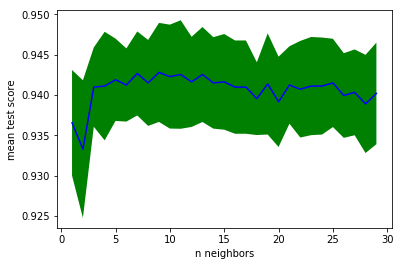

In [20]:
x,y,err=params['n_neighbors'],clf_knn.cv_results_['mean_test_score'],clf_knn.cv_results_['std_test_score']
plt.plot(x,y,'b')
plt.xlabel('n neighbors')
plt.ylabel('mean test score')
plt.fill_between(x,y-err,y+err,facecolor='green')
plt.show()

Проверим какой svm работает лучше: линейный или с rbf ядром. 

In [28]:
svc = SVC()
params={'kernel':['linear','rbf']}
clf_svc = GridSearchCV(svc, params,cv=5)
clf_svc.fit(data_mean, label)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'kernel': ['linear', 'rbf']}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

In [29]:
clf_svc.cv_results_['mean_test_score']

array([ 0.9498306 ,  0.93262966])

Наивный байесовский классификатор работает хуже.

In [134]:
clf_bnb=BernoulliNB()
score_bnb=cross_val_score(clf_bnb,data_mean,label,cv=5)

In [135]:
score_bnb.mean()

0.87956755402273801

Сравним ансамбли деревьев. Extra trees classifier показал больший результат, чем random forest.

In [81]:
clf_rf=RandomForestClassifier(n_estimators=200)
score_rf=cross_val_score(clf_rf,data_mean,label,cv=5)

In [83]:
score_rf.mean()

0.94852070246516451

In [84]:
clf_trees=ExtraTreesClassifier(n_estimators=200)
score_trees=cross_val_score(clf_trees,data_mean,label,cv=5)

In [85]:
score_trees.mean()

0.95125610820177919

Исследуем гиперпараметры: максимальную глубину деревьев и максисальное количествой признаков, используемое деревом.

In [96]:
params={'max_depth':np.arange(1,50,5)}
clf_trees = GridSearchCV(clf_trees, params,cv=5)
clf_trees.fit(data_mean, label)

GridSearchCV(cv=5, error_score='raise',
       estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

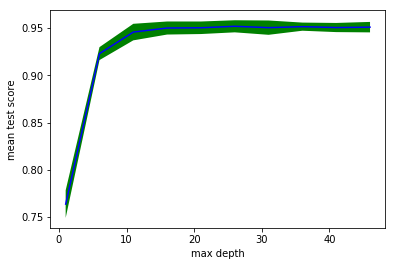

In [97]:
x,y,err=params['max_depth'],clf_trees.cv_results_['mean_test_score'],clf_trees.cv_results_['std_test_score']
plt.plot(x,y,'b')
plt.xlabel('max depth')
plt.ylabel('mean test score')
plt.fill_between(x,y-err,y+err,facecolor='green')
plt.show()

In [103]:
clf_trees=ExtraTreesClassifier(n_estimators=200)
params={'max_features':np.arange(1,100,10)}
clf_trees = GridSearchCV(clf_trees, params,cv=5)
clf_trees.fit(data_mean, label)

GridSearchCV(cv=5, error_score='raise',
       estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

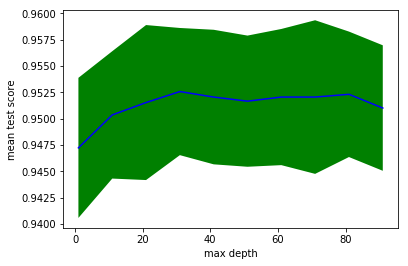

In [104]:
x,y,err=params['max_features'],clf_trees.cv_results_['mean_test_score'],clf_trees.cv_results_['std_test_score']
plt.plot(x,y,'b')
plt.xlabel('max features')
plt.ylabel('mean test score')
plt.fill_between(x,y-err,y+err,facecolor='green')
plt.show()

Теперь сравним результаты лучших моделей по-разному обработанных текстах (обычное или взвешенное среднее).

In [164]:
knn = KNeighborsClassifier(n_neighbors=clf_knn.best_params_['n_neighbors'])
svc = SVC(kernel='linear')
trees=ExtraTreesClassifier(n_estimators=200,max_features=30)

In [165]:
results=pd.DataFrame(index=['knn','svc_linear','extra_trees'],columns=['mean','tfidf'])

In [168]:
scores=[]
for data in [data_mean,data_tfidf]:
    for clf in [knn,svc,trees]:
        scores.append(cross_val_score(clf,data,label,cv=5).mean())    

Результаты (особенно результат линейного svm) значительно улучшились благодаря idf весам.

In [169]:
results['mean']=scores[:3]
results['tfidf']=scores[-3:]
results

,mean,tfidf
knn,0.942784,0.946177
svc_linear,0.949825,0.957124
extra_trees,0.951906,0.954774


# News

Попробуем взять другие тексты. Это статьи из новостной газеты, размеченные по 20 темам.

In [194]:
X, y = [], []
with open('20ng-no-stop.txt') as infile:
    for line in infile:
        label, text = line.split("\t")
        # texts are already tokenized, just split on space
        # in a real case we would use e.g. spaCy for tokenization
        # and maybe remove stopwords etc.
        X.append(text.split())
        y.append(label)
X, y = np.array(X), np.array(y)

In [195]:
model = word2vec.Word2Vec(X, size=100, window=10, workers=2)

2017-04-24 00:27:10,316 : INFO : collecting all words and their counts
2017-04-24 00:27:10,318 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-04-24 00:27:10,714 : INFO : PROGRESS: at sentence #10000, processed 1321764 words, keeping 65410 word types
2017-04-24 00:27:11,077 : INFO : collected 92811 word types from a corpus of 2654769 raw words and 18821 sentences
2017-04-24 00:27:11,078 : INFO : Loading a fresh vocabulary
2017-04-24 00:27:11,246 : INFO : min_count=5 retains 32816 unique words (35% of original 92811, drops 59995)
2017-04-24 00:27:11,248 : INFO : min_count=5 leaves 2550366 word corpus (96% of original 2654769, drops 104403)
2017-04-24 00:27:11,368 : INFO : deleting the raw counts dictionary of 92811 items
2017-04-24 00:27:11,372 : INFO : sample=0.001 downsamples 16 most-common words
2017-04-24 00:27:11,374 : INFO : downsampling leaves estimated 2275837 word corpus (89.2% of prior 2550366)
2017-04-24 00:27:11,377 : INFO : estimated required

In [196]:
w2v = dict(zip(model.wv.index2word, model.wv.syn0))

In [197]:
data_mean=mean_vectorizer(w2v).fit(X).transform(X)
data_tfidf=tfidf_vectorizer(w2v).fit(X).transform(X)
label=y

In [198]:
scores=[]
for data in [data_mean,data_tfidf]:
    for clf in [knn,svc,trees]:
        scores.append(cross_val_score(clf,data,label,cv=5).mean())    

Результаты уже не такие хорошие. Причем я проверила, что увеличение окна при обучении word2vec улучшило результат. Можно скачать уже обученный word2vec от google. Ну и конечно усредняя векторы слов в тексте мы теряем информацию. Можно разбить текст на фразы и обучаться на них. Еще можно сохранить предсказания и добавить еще признаков (в зависимости от задачи, например, количество слов из данного кластера)  и обучиться поверх. 

In [199]:
results['mean']=scores[:3]
results['tfidf']=scores[-3:]
results

,mean,tfidf
knn,0.566983,0.612190
svc_linear,0.663517,0.714843
extra_trees,0.613420,0.658264
